In [192]:
import matplotlib.pyplot as plt
import pandas as pd
from data_preparer import DataPreparer
from allocator import Allocator
import pickle
import numpy as np

In [193]:
def get_filtered_universe(preparer_obj, ts, tx, threshold, snapshot_start_id=0, snapshot_end_id=5):
    preparer_obj.prepare_snapshots(weight_combination={"ts":ts, "tx":tx}, threshold=threshold)
    preparer_obj.calculate_similarity_matrix(node_count=200, snapshot_start_id=snapshot_start_id, snapshot_end_id=snapshot_end_id)
    preparer_obj.calculate_final_communes()
    node_metrics = preparer_obj.calculate_node_metrics()
    node_metrics["stock"] = preparer.stock2id.index
    
    centrality_threshold = node_metrics.centrality.mean()
    investment_universe = node_metrics.reset_index()[(node_metrics.centrality < centrality_threshold)]
    pagerank_threshold = investment_universe.pagerank.mean() + investment_universe.pagerank.std() / 2
    investment_universe = investment_universe[(investment_universe.pagerank > pagerank_threshold)]
    
    return investment_universe.stock

In [ ]:
iteration_count = 5

allocation_results = {
                      "pearson": {"path": "calculated_data/historical_ts_sim_pearson.pkl"},
                      "dist_corr": {"path": "calculated_data/historical_ts_sim_distCorr.pkl"},
                      "euclidean": {"path": "calculated_data/historical_ts_sim.pkl"}, 
                      "dtw": {"path": "calculated_data/historical_ts_sim_dtw.pkl"}
                      }
hybrid_weights = {
    "dist_corr": [0.55, 0.45, 0.35], # ts, tx, threshold
    "pearson": [0.45, 0.55, 0.3],
    "dtw": [0.95, 0.05, 0.2],
    "euclidean": [0.35, 0.65, 0.25]
}
combinations = [{"id":0, "ts": 0.55, "tx": 0.45}, {"id":1, "ts": 0.0, "tx": 1.0}, {"id":2, "ts": 1.0, "tx": 0.0}]
 
preparer = DataPreparer(
        data_path="cold_data/description_vectors.pkl",
        textual_path="cold_data/textual_information.csv",
        stock2idPath="cold_data/stock2id.csv",
        stockDataPath="cold_data/stock_data.csv"
)
allocator = Allocator()
trade_start_date = "2023-05-26"

for sim_metric in list(allocation_results.keys()):    
    with open(allocation_results[sim_metric]["path"], "rb") as f:
        ts_sim = pickle.load(f)
    
    filtered_sims = {}
    
    for k in list(ts_sim.keys())[:6]:
        filtered_sims[k] = ts_sim[k]
        
    preparer.ts_similarities = filtered_sims
    
    for combination_id, combination in enumerate(combinations):
        if combination_id == 0:
            ts, tx, threshold = hybrid_weights[sim_metric]
            id = 0
        elif combination_id == 1:
            ts, tx, threshold = 0, 1, 0.2
            id = 1
        else:
            id, ts, tx = combination["id"], combination["ts"], combination["tx"]
            threshold = 0.2
            
        allocation_results[sim_metric][id] = []
        
        returns = []
        filtered_sizes = []
        for iteration in range(iteration_count):
            selected_stocks = get_filtered_universe(preparer, ts, tx, threshold=threshold)
            filtered_optim = allocator.mean_variance_optimization(
                preparer.stockData[(preparer.stockData.index < trade_start_date) & 
                                   (preparer.stockData.index > "2023-01-01")][selected_stocks], min_weight=0.01, take_pct_change=True
            )
            filtered_return = allocator.calculate_cumulative_return(
                filtered_optim[filtered_optim.weights > 0], 
                stockData=preparer.stockData, 
                startDate=trade_start_date
            )
            allocation_results[sim_metric][id].append(filtered_return[1])
            
            filtered_sizes.append(len(selected_stocks))
            returns.append(filtered_return[1][-1])
            
        print("\nSim. Metric:", sim_metric, 
              "TS Weight:", ts, "TX Weight:", tx) 
        print("Avg. Return:", np.mean(returns), "Avg. Std:", np.std(returns))
        print("Avg. Size of Filtered Universe:", np.mean(filtered_sizes)) 

In [195]:
mean_variance_optim = allocator.mean_variance_optimization(preparer.stockData[(preparer.stockData.index < trade_start_date)&(preparer.stockData.index >"2023-01-01")], 
                                                           min_weight=0.01, take_pct_change=True) 
mean_variance_return = allocator.calculate_cumulative_return(mean_variance_optim[mean_variance_optim.weights > 0], stockData=preparer.stockData, startDate=trade_start_date)

print("Return:", mean_variance_return[0])

You must convert self.cov to a positive definite matrix
Return: 0.5007765461220697


In [214]:
with open("allocation_results_sp.pkl", 'wb') as file:
    pickle.dump(allocation_results, file)

# Detailed Visualization

In [ ]:
import datetime
import matplotlib.dates as mdates

invest_data = preparer.stockData[(preparer.stockData.index > trade_start_date)]
data_index = np.array(invest_data.index)
data_index = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in data_index]

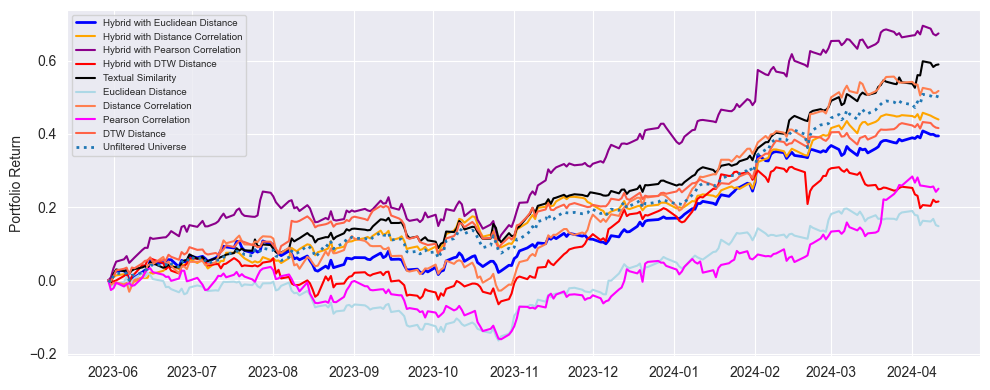

In [213]:
# Plot 1
plt.figure(figsize=(10, 4))
plt.plot(pd.Series(np.mean(allocation_results["euclidean"][0], axis=0), index=data_index), label="Hybrid with Euclidean Distance", color="blue",  linewidth=2)
plt.plot(pd.Series(np.mean(allocation_results["dist_corr"][0], axis=0), index=data_index), label="Hybrid with Distance Correlation", color="orange")
plt.plot(pd.Series(np.mean(allocation_results["pearson"][0], axis=0), index=data_index), label="Hybrid with Pearson Correlation", color="darkmagenta")
plt.plot(pd.Series(np.mean(allocation_results["dtw"][0], axis=0), index=data_index), label="Hybrid with DTW Distance", color="red")
plt.plot(pd.Series(np.mean(allocation_results["euclidean"][1], axis=0), index=data_index), label="Textual Similarity", color="black")

plt.plot(pd.Series(np.mean(allocation_results["euclidean"][2], axis=0), index=data_index), label="Euclidean Distance", color="lightblue")
plt.plot(pd.Series(np.mean(allocation_results["dist_corr"][2], axis=0), index=data_index), label="Distance Correlation", color="coral")
plt.plot(pd.Series(np.mean(allocation_results["pearson"][2], axis=0), index=data_index), label="Pearson Correlation", color="magenta")
plt.plot(pd.Series(np.mean(allocation_results["dtw"][2], axis=0), index=data_index), label="DTW Distance", color="tomato")

plt.plot(pd.Series(mean_variance_return[1], index=data_index), label="Unfiltered Universe", linestyle="dotted", linewidth=2)

# plt.xlabel('Date')
plt.ylabel("Portfolio Return")
plt.legend(prop={'size': 7})

plt.tight_layout()
plt.savefig('portfolio_returns_combined.png', dpi=300, bbox_inches='tight')

In [16]:
preparer = DataPreparer(
        data_path="cold_data/description_vectors.pkl",
        textual_path="cold_data/textual_information.csv",
        stock2idPath="cold_data/stock2id.csv",
        stockDataPath="cold_data/stock_data.csv"
)

with open("calculated_data/historical_ts_sim_pearson.pkl", "rb") as f:
    ts_sim = pickle.load(f)
    
filtered_sims = {}
    
for k in list(ts_sim.keys())[:6]:
    filtered_sims[k] = ts_sim[k]
        
preparer.ts_similarities = filtered_sims
preparer.prepare_snapshots({"ts": 0.45, "tx": 0.55}, threshold=0.3)
preparer.calculate_similarity_matrix(node_count=200)
preparer.calculate_final_communes()
node_metrics = preparer.calculate_node_metrics()

In [59]:
centrality_threshold = round(node_metrics.centrality.mean(), 3)

filtered = node_metrics[node_metrics.centrality < centrality_threshold]
pagerank_threshold = filtered.pagerank.mean() + (filtered.pagerank.std() / 2)
selected = filtered[filtered.pagerank > pagerank_threshold]

print(len(node_metrics), len(filtered), len(selected))
print("Pagerank Mean:", pagerank_threshold, "Pagerank Std:", round(filtered.pagerank.std(), 3))
print("Closeness Mean:", centrality_threshold, "Closeness Std:", round(node_metrics.centrality.std(), 3))

200 149 45
Pagerank Mean: 0.005593557365602213 Pagerank Std: 0.001
Closeness Mean: 0.454 Closeness Std: 0.265


In [48]:
node_metrics["stock"] = preparer.stock2id.index
node_metrics["name"] = preparer.textual_information.name
node_metrics["sector"] = preparer.textual_information.sector

In [119]:
pagerankbysector = node_metrics.groupby("sector").pagerank.mean().sort_values()
centralitybysector = node_metrics.groupby("sector").centrality.mean().sort_values()
sectorcounts = node_metrics.sector.value_counts().sort_values()
selected_sector_counts = selected.sector.value_counts()

scores_df = pd.merge(left=pagerankbysector, right=centralitybysector, left_index=True, right_index=True)
counts_df = pd.merge(left=sectorcounts, right=selected_sector_counts, left_index=True, right_index=True)
counts_df.columns = ["initial count", "selection count"]

In [120]:
unselected_sector = np.setdiff1d(scores_df.index, counts_df.index)[0]

In [121]:
scores_df.loc[unselected_sector], sectorcounts.loc[unselected_sector]

(pagerank      0.004736
 centrality    0.437743
 Name: Consumer Defensive, dtype: float64,
 16)

In [122]:
scores_df = pd.merge(right=counts_df, left=scores_df, left_index=True, right_index=True)

In [123]:
scores_df.loc["Consumer Defensive"] = {"pagerank": 0.0047, "centrality": 0.4377, "initial count":16, "selection count":0}

In [127]:
scores_df

,pagerank,centrality,initial count,selection count
sector,,,,
Basic Materials,0.004165,0.336779,7,3
Industrials,0.004672,0.452683,20,3
Energy,0.004804,0.431189,19,4
Consumer Cyclical,0.004822,0.413456,26,6
Financial Services,0.004918,0.477761,25,4
Utilities,0.004956,0.396011,15,6
Technology,0.005190,0.514024,30,10
Real Estate,0.005363,0.423822,8,2
Communication Services,0.005517,0.466631,14,2


In [142]:
g_final = preparer.np2igraph(preparer.get_similarity_matrix())
metrics = node_metrics[["sector", "commune", "stock"]]

In [185]:
commune_sector_pairs = metrics.merge(metrics, on='commune')
cross_tab = pd.crosstab(commune_sector_pairs['sector_x'], commune_sector_pairs['sector_y'])
cross_tab / cross_tab.sum(axis=1)

sector_y,Basic Materials,Communication Services,Consumer Cyclical,Consumer Defensive,Energy,Financial Services,Healthcare,Industrials,Real Estate,Technology,Utilities
sector_x,,,,,,,,,,,
Basic Materials,0.200000,0.01250,0.028926,0.006024,0.014563,0.022222,0.008658,0.030769,0.008333,0.012085,0.024631
Communication Services,0.044444,0.15000,0.082645,0.048193,0.063107,0.075556,0.060606,0.051282,0.058333,0.096677,0.064039
Consumer Cyclical,0.155556,0.12500,0.214876,0.120482,0.072816,0.097778,0.095238,0.097436,0.100000,0.099698,0.098522
Consumer Defensive,0.022222,0.05000,0.082645,0.144578,0.077670,0.066667,0.077922,0.061538,0.100000,0.081571,0.064039
Energy,0.066667,0.08125,0.061983,0.096386,0.169903,0.102222,0.099567,0.097436,0.116667,0.090634,0.073892
Financial Services,0.111111,0.10625,0.090909,0.090361,0.111650,0.182222,0.082251,0.097436,0.058333,0.111782,0.098522
Healthcare,0.044444,0.08750,0.090909,0.108434,0.111650,0.084444,0.173160,0.112821,0.125000,0.084592,0.137931
Industrials,0.133333,0.06250,0.078512,0.072289,0.092233,0.084444,0.095238,0.164103,0.091667,0.075529,0.098522
Real Estate,0.022222,0.04375,0.049587,0.072289,0.067961,0.031111,0.064935,0.056410,0.166667,0.024169,0.064039


In [190]:
centrality_threshold, pagerank_threshold

(0.454, 0.005593557365602213)

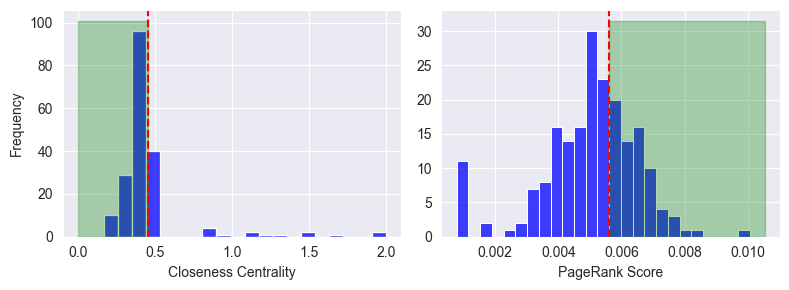

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd  

# Create a new figure with appropriate size
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 3)) 

# Plot the closeness centrality histogram
sns.histplot(node_metrics.centrality, bins=20, kde=False, ax=ax1, color='blue')
ax1.axvline(centrality_threshold, color='r', linestyle='--', label=f'Centrality Threshold: {round(centrality_threshold, 3)}')
ax1.fill_betweenx([0, ax1.get_ylim()[1]], x1=0, x2=centrality_threshold, color='green', alpha=0.3)
ax1.set_xlabel('Closeness Centrality')
ax1.set_ylabel('Frequency')
# ax1.legend()


# Plot the PageRank histogram
sns.histplot(node_metrics.pagerank, bins=25, kde=False, ax=ax2, color='blue')
ax2.axvline(pagerank_threshold, color='r', linestyle='--')
ax2.fill_betweenx([0, ax2.get_ylim()[1]], x1=pagerank_threshold, x2=ax2.get_xlim()[1], color='green', alpha=0.3)
ax2.set_xlabel('PageRank Score')
ax2.set_ylabel('')
# ax2.legend()

plt.tight_layout() 

plt.savefig('distributions_histogram.png', dpi=300, bbox_inches='tight')
plt.show()